## YouTube's Inner World: A Data Exploration of Channel and Video Dynamics

Based on large-Scale channel and video Metadata from English-Speaking YouTube, we have a deep dive into this dataset. Featuring on time series analysis, statistical analysis, we explore, analyze, and concentrate the trends and characteristics of YouTube's channel. Insights are unlocked and shown at advanced visualization way.

#### Research Group
- **Group Name**: Laughtodeath666
- Shengze Jiang, Shengze.jiang@epfl.ch
- Shuhua Chen, Shuhua.chen@epfl.ch
- Xuanrui Li, xuanrui.li@epfl.ch
- Xinran Li, xinran.li@epfl.ch
- Xinyue Zhang, xinyue.zhang@epfl.ch


#### Dataset description
- `df_channels_en.tsv.gz`: contains data related to channel, category, join data, channel id & name, subscribers, rank, ect.
    - `category_cc`: category of the channel
    - `join_date`: join date of the channel
    - `channel`: channel id
    - `name_cc`: name of the channel
    - `subscribers_cc`: number of subscribers
    - `videos_cc`: number of videos
    - `subscriber_rank_sb`: rank in terms of number of subscribers
    - `weights`: weights cal
    - Note: 
        136,470 rows in total; 
        obtain it in 27/10/2019; 
        filter non-english channels.
- `df_timeseries_en.csv.gz`: latest category, datetime, views, subs, videos, and their changing amount.
    - `channel`: channel id
    - `category`: category according to the last 10 videos at time of crawl
    - `datetime`: week related to the data point
    - `views`: total number of views the channel had this week
    - `delta_views`: delta subscribers obtained this week
    - `subs`: total number of subscribers the channel had this week
    - `delta_subs`: rank in terms of number of subscribers
    - `videos`: total number of videos the channel had this week
    - `delta_videos`: delta videos obtained this week
    - `activity`: number of videos published in the last 15 days
    - Note: 18,872,499 data points belonging to 153,550 channels; 2.8 years of data for each channel in average; filter non-english channels; Data goes from early/01/2015 to end/09/2019 (incomplete time frame for some channels)
- `yt_metadata_en.jsonl.gz`: for each video of every channel, category, description, like/dislike counts, duration, tags, views, etc.
- `youtube_comments.tsv.gz`: anonymized user id, video id, replies, and likes received.

#### Our Tasks
- **Overall Profile Analysis**: Visualize the distributions, correlations, and trends of each feature.
- **Duration Modeling and Analysis**: Taking multiple factors into account, model the duration-orientated comprehensive judging model.
- **YouTube channel strategies**: Analyze the impact of diversification and specialization strategies on channels.

#### Main Ideas
- **Jack of all trades or master of one**: We wonder if YouTube creators should stick to one topic or mix it up. We can investigate this by analyzing three key aspects: the impact of content diversity on channel growth and engagement, long-term performance comparison between specialized and diversified channels, and common characteristics of successful diversification strategies.
- **Analysis of video duration**: We are interested in the impact of video duration. Will people prefer a longer video as they may get more knowledge, or they prefer a short video for passing time? We can explore this by investigating three aspects: optimal video length for different categories, the impact of video length on viewer engagement and channel growth, and the evolution of audience preferences for video length over time. Also, we are going to develop a method to evaluate the popular degree of a video, then focus on the relationship between video duration and popular degree.

### *Data Preprocessing*

In this section, we will preprocess the data to ensure that it is clean and ready for analysis.

First, we will sample the data to reduce the size of the dataset and improve processing speed. Then we will address missing values, filter the data, and calculate relevant metrics for our analysis. Finally, we will perform exploratory data analysis to understand the structure and content of the data.

In [3]:
# sample data
# %run src/data/sample_data.ipynb

In [4]:
# Import data
import pandas as pd
from rich.jupyter import display

from src.data.loader import load_data

df_id, df_channels, df_timeseries, df_comments, df_metadata = load_data()

In [5]:
# View column names and data types of each dataframe
for df_name, df in [('df_id', df_id), 
                    ('df_channels', df_channels),
                    ('df_timeseries', df_timeseries), 
                    ('df_comments', df_comments),
                    ('df_metadata', df_metadata)]:
    print(f"\n{df_name} columns:")
    print(df.info())


df_id columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13633 entries, 0 to 13632
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   channel  13633 non-null  object
dtypes: object(1)
memory usage: 106.6+ KB
None

df_channels columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13633 entries, 0 to 13632
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   category_cc         13633 non-null  object 
 1   join_date           13633 non-null  object 
 2   channel             13633 non-null  object 
 3   name_cc             13633 non-null  object 
 4   subscribers_cc      13633 non-null  int64  
 5   videos_cc           13633 non-null  int64  
 6   subscriber_rank_sb  13633 non-null  float64
 7   weights             13633 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 852.2+ KB
None

df_timeseries columns:
<clas

In [6]:
# Check missing values in each dataframe
for df_name, df in [('df_id', df_id), 
                    ('df_channels', df_channels),
                    ('df_timeseries', df_timeseries), 
                    ('df_comments', df_comments),
                    ('df_metadata', df_metadata)]:
    print(f"\n{df_name} missing values:")
    print(df.isna().sum())


df_id missing values:
channel    0
dtype: int64

df_channels missing values:
category_cc           0
join_date             0
channel               0
name_cc               0
subscribers_cc        0
videos_cc             0
subscriber_rank_sb    0
weights               0
dtype: int64

df_timeseries missing values:
channel         0
category        0
datetime        0
views           0
delta_views     0
subs            0
delta_subs      0
videos          0
delta_videos    0
activity        0
dtype: int64

df_comments missing values:
display_id    0
num_comms     0
dtype: int64

df_metadata missing values:
categories            0
channel_id            0
dislike_count    171758
display_id            0
duration              0
like_count       171758
upload_date           0
view_count           33
dtype: int64


We have identified the sources of missing/NaN data in each of our dataframes. The 'df_metadata' contains missing values in the 'dislike_count', 'like_count', and 'view_count' columns, with 171758 missing values in both 'dislike_count' and 'like_count', and 33 missing values in 'view_count'. All other dataframes have no missing values in any columns. Therefore, to address these missing values, we can fill them by calculating the mean based on 'channel_id'.

In [7]:
# fill missing values 
from src.data.preprocessor import fill_channel_means

df_metadata=fill_channel_means(df_metadata, ['dislike_count','like_count' ,'view_count'])
print(pd.isna(df_metadata).sum())

categories       0
channel_id       0
dislike_count    0
display_id       0
duration         0
like_count       0
upload_date      0
view_count       0
dtype: int64


In [8]:
df_id.head(10)

,channel
0,UC8vVgIytHRD8aJeYINpG1kQ
1,UCxg6sQ9zDWu0b5DK0Ck9vjA
2,UCsAegdhiYLEoaFGuJFVrqFQ
3,UCPl2eZVyzL-qI9n8III1jRQ
4,UCkaBrf3FRFWxXg6FEfIjgUA
5,UCdOXRB936PKSwx0J7SgF6SQ
6,UCnUOLTxgO9C1I4cgj3GshAA
7,UCHVLKMhgZL5O08rjSx3QpQA
8,UC9sJElk83diXHdvVE8Fbz1A
9,UCb06PxivXgwX3qj1JEWmwrw


In [9]:
df_channels.head(10)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Autos & Vehicles,2006-07-21,UC8vVgIytHRD8aJeYINpG1kQ,vsandvs,11500,1055,838440.0,10.8730
1,Autos & Vehicles,2009-01-21,UCxg6sQ9zDWu0b5DK0Ck9vjA,V12 Productions,14100,274,737004.0,9.3105
2,Autos & Vehicles,2006-03-11,UCsAegdhiYLEoaFGuJFVrqFQ,MotorTrend Channel,6380000,2231,1160.0,2.0870
3,Autos & Vehicles,2010-08-02,UCPl2eZVyzL-qI9n8III1jRQ,Mercedes-Benz MYVAN,25780,304,471490.0,7.5720
4,Autos & Vehicles,2013-10-13,UCkaBrf3FRFWxXg6FEfIjgUA,fz09 dave,22000,92,519580.0,9.4240
5,Autos & Vehicles,2015-06-11,UCdOXRB936PKSwx0J7SgF6SQ,EddieX,84500,331,184399.0,4.5440
6,Autos & Vehicles,2008-08-30,UCnUOLTxgO9C1I4cgj3GshAA,SmallEngineMechanic,30100,292,398177.0,6.4970
7,Autos & Vehicles,2014-03-06,UCHVLKMhgZL5O08rjSx3QpQA,trailsoffroad.com,11200,1041,815295.0,12.0045
8,Autos & Vehicles,2015-12-17,UC9sJElk83diXHdvVE8Fbz1A,Money4yourMotors Lim...,10561,232,907859.0,15.3590
9,Autos & Vehicles,2012-10-02,UCb06PxivXgwX3qj1JEWmwrw,Galaxy89cars,25188,439,458635.0,8.8015


In [10]:
df_timeseries.head(10)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
714,UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2016-08-01 00:00:00,1.530218e+07,13128.000,70608.625,0.000,92,0,1
715,UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2016-08-08 00:00:00,1.532940e+07,27218.250,70709.500,100.875,93,1,2
716,UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2016-08-15 00:00:00,1.535108e+07,21688.500,70794.250,84.750,93,0,1
717,UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2016-08-22 00:00:00,1.539080e+07,39716.250,70936.000,141.750,94,1,1
718,UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2016-08-29 00:00:00,1.541910e+07,28302.750,71038.375,102.375,94,0,1
719,UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2016-09-05 00:00:00,1.545100e+07,31896.750,71117.500,79.125,94,0,0
720,UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2016-09-12 00:00:00,1.537658e+07,0.000,71210.875,93.375,96,2,2
721,UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2016-09-19 00:00:00,1.534019e+07,0.000,71301.000,90.125,96,0,2
722,UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2016-09-26 00:00:00,1.536618e+07,25985.875,71377.625,76.625,97,1,2
723,UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2016-10-03 00:00:00,1.539366e+07,27485.375,71456.750,79.125,97,0,1


In [11]:
df_comments.head(10)

,display_id,num_comms
11303,aJUPKst0VWE,1.0
11304,1nD8xqURS_8,1.0
11305,JP8bObJpx7w,2.0
11306,CecDZi3WeSE,1.0
11307,ptBLjEa-TBM,1.0
11308,QMV0n63mJNk,3.0
11309,NhQro0dE1qA,0.0
11310,Ko7pe2Jyew8,0.0
11311,ECV9GeQozFM,0.0
11312,hAt7LbKA-sw,1.0


In [12]:
df_metadata.head(10)

,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count
0,Science & Technology,UCzWA3ov9kcza5XxtHh-lM7Q,3.0,aJUPKst0VWE,319,22.0,2019-09-09,384.0
1,Science & Technology,UCzWA3ov9kcza5XxtHh-lM7Q,0.0,1nD8xqURS_8,729,29.0,2019-09-08,591.0
2,Science & Technology,UCzWA3ov9kcza5XxtHh-lM7Q,8.0,JP8bObJpx7w,629,44.0,2019-08-27,1397.0
3,Science & Technology,UCzWA3ov9kcza5XxtHh-lM7Q,0.0,CecDZi3WeSE,496,28.0,2019-06-03,456.0
4,Science & Technology,UCzWA3ov9kcza5XxtHh-lM7Q,1.0,ptBLjEa-TBM,25,12.0,2019-06-02,323.0
5,Science & Technology,UCzWA3ov9kcza5XxtHh-lM7Q,4.0,QMV0n63mJNk,2235,26.0,2019-06-02,352.0
6,Science & Technology,UCzWA3ov9kcza5XxtHh-lM7Q,2.0,NhQro0dE1qA,764,30.0,2019-04-22,464.0
7,Science & Technology,UCzWA3ov9kcza5XxtHh-lM7Q,3.0,Ko7pe2Jyew8,2115,28.0,2019-04-17,574.0
8,Science & Technology,UCzWA3ov9kcza5XxtHh-lM7Q,3.0,ECV9GeQozFM,317,20.0,2019-04-17,331.0
9,Science & Technology,UCzWA3ov9kcza5XxtHh-lM7Q,3.0,hAt7LbKA-sw,96,16.0,2019-04-16,404.0


### *IDEA1: Jack of all trades or master of one*
We wonder if YouTube creators should stick to one topic or mix it up. We can investigate this by analyzing three key aspects: the impact of content diversity on channel growth and engagement, long-term performance comparison between specialized and diversified channels, and common characteristics of successful diversification strategies

#### Mathematical Details
1. **Channel Content Diversity (Shannon's Entropy)**:

    For a channel's content categories:
    
    $H = -\sum_{i=1}^{n} p_i \ln(p_i)$, where:
    
    $H$ = Shannon's diversity index
    
    $p_i$ = proportion of videos in category $i$
    
    $n$ = total number of categories
    
2. **Engagement Rate**:

    $ER = \min(\frac{L}{V} \times 100, 100)$, where:
    
    $L$ = likes
    
    $V$ = views
    
3. **Growth Rates**:

    Weekly growth rates:
    
    $G_s = \frac{S_f - S_i}{w}$
    
    $G_v = \frac{V_f - V_i}{w}$, where:
    
    $G_s$ = subscriber growth rate
    
    $G_v$ = view growth rate
    
    $S_f, V_f$ = final values
    
    $S_i, V_i$ = initial values
    
    $w$ = number of weeks

In [13]:
from src.utils.content import preprocess_data, calculate_channel_metrics

print("Preprocessing data...")
filtered_metadata, filtered_timeseries = preprocess_data(df_metadata, df_timeseries, 0)
    
print("Calculating channel metrics...")
merged_metrics = calculate_channel_metrics(filtered_metadata, filtered_timeseries)
print(merged_metrics.info())

Preprocessing data...
Calculating channel metrics...
<class 'pandas.core.frame.DataFrame'>
Index: 13345 entries, 0 to 13632
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   channel_id           13345 non-null  object  
 1   view_count           13345 non-null  float64 
 2   like_count           13345 non-null  float64 
 3   categories           13345 non-null  object  
 4   engagement_rate      13345 non-null  float64 
 5   diversity            13345 non-null  float64 
 6   num_categories       13345 non-null  int64   
 7   main_category        13345 non-null  object  
 8   main_category_ratio  13345 non-null  float64 
 9   sub_growth           13345 non-null  float64 
 10  weeks                13345 non-null  float64 
 11  view_growth          13345 non-null  float64 
 12  final_views          13345 non-null  float64 
 13  final_subs           13345 non-null  float64 
 14  weekly_sub_growth    1

In [14]:
from src.utils.content import identify_patterns

print("Identifying success patterns...")
patterns, successful_channels = identify_patterns(merged_metrics)

Identifying success patterns...

=== Content Strategy Analysis Results ===

Number of successful channels: 7471
Average diversity index: 0.33
Average number of categories: 2.8
Average main category ratio: 87.2%
Average views: 664,421
Average engagement: 0.024
Average weekly subscriber growth: 2422.2
Average weekly view growth: 676904.2
Average active weeks: 132.3

Successful Strategy Characteristics:

Strategy: Specialized
Proportion: 81.4%
Weekly average subscriber growth: 2530.7
Weekly average view growth: 717,751
Content diversity: 0.18

Strategy: Mixed
Proportion: 17.2%
Weekly average subscriber growth: 1988.3
Weekly average view growth: 507,182
Content diversity: 0.91

Strategy: Diversified
Proportion: 1.5%
Weekly average subscriber growth: 1478.0
Weekly average view growth: 396,569
Content diversity: 1.53


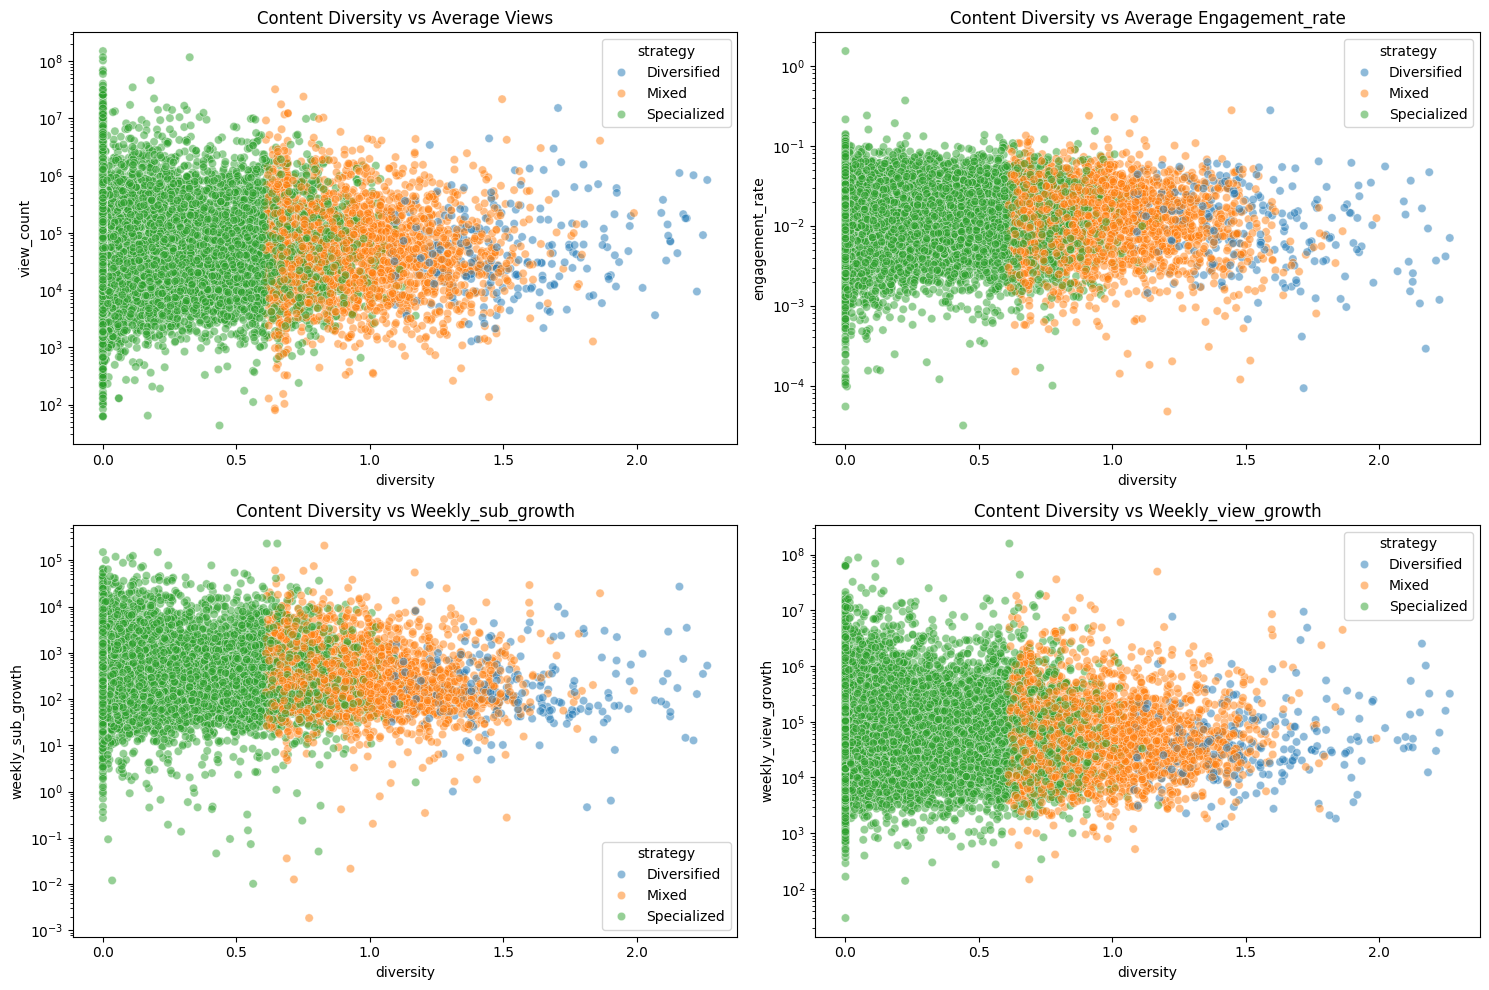

In [15]:
from src.utils.content import diversity_plot_insights

# Create key insight visualizations
plot = diversity_plot_insights(merged_metrics)

In [16]:
# Categories Ratio of Successful Specialized and Diversified Channels
successful_Specialized = successful_channels[successful_channels['strategy'] == 'Specialized'].sort_values('view_count',ascending=False).reset_index(
    drop=True)
successful_Specialized_types = []
for i in range(len(successful_Specialized)):
    successful_Specialized_types += successful_Specialized['categories'][i]
print("Video Categories Ratio of Successful Specialized Channels:")
print(pd.Series(successful_Specialized_types).value_counts(normalize=True))

successful_Diversified = successful_channels[successful_channels['strategy']=='Diversified'].sort_values('view_count', ascending=False).reset_index(drop=True)
successful_Diversified_types=[]
for i in range(len(successful_Diversified)):
    successful_Diversified_types+=successful_Diversified['categories'][i]
print("\nVideo Categories Ratio of Successful Diversified Channels:")
print(pd.Series(successful_Diversified_types).value_counts(normalize=True))

Video Categories Ratio of Successful Specialized Channels:
Gaming                   0.192941
News & Politics          0.191292
Entertainment            0.177135
Music                    0.102704
People & Blogs           0.072568
Sports                   0.070196
Education                0.049000
Howto & Style            0.045284
Film & Animation         0.028690
Science & Technology     0.019817
Autos & Vehicles         0.016746
Comedy                   0.015852
Travel & Events          0.008544
Pets & Animals           0.006652
Nonprofits & Activism    0.002579
                         0.000002
Name: proportion, dtype: float64

Video Categories Ratio of Successful Diversified Channels:
Entertainment            0.267931
Film & Animation         0.226157
News & Politics          0.169917
People & Blogs           0.073494
Comedy                   0.049909
Music                    0.042086
Howto & Style            0.034935
Education                0.033032
Autos & Vehicles         0.02558

Based on the data shown in the image, I can provide the following analysis regarding channel specialization vs. diversification:

1. Category Distribution Analysis:
- For specialized channels:
  * Gaming (19.3%) and News & Politics (19.1%) lead the success rates
  * Entertainment follows at 17.7%
  * These three categories account for over 56% of successful specialized channels

- For diversified channels:
  * Entertainment dominates at 26.8%
  * Film & Animation shows strong performance at 22.6%
  * News & Politics maintains significance at 17%
  * These top three categories represent about 66% of successful diversified channels

2. Notable Contrasts:
- Film & Animation shows a remarkable pattern:
  * 0.03% success rate in specialized channels
  * 22.6% success rate in diversified channels
- Gaming:
  * Tops specialized channels at 19.3%
  * Absent from top performing diversified channels

3. Key Recommendations:
- For Specialized Strategy:
  * Focus on Gaming, News & Politics, or Entertainment
  * These categories have proven track records for specialized success
  * Clear audience targeting and content focus appear beneficial

- For Diversification Strategy:
  * Center content around Entertainment as the primary category
  * Consider Film & Animation or News & Politics as major components
  * These categories show strong performance in diversified approaches

4. Strategic Implications:
The data suggests two viable paths to channel success:
- A focused, specialized approach in high-performing categories
- A diversified strategy centered on entertainment and visual content

This analysis supports the initial insights that reducing video categories (specialization) can be effective, while those choosing diversification should prioritize Entertainment, Film & Animation, or News & Politics as their main content categories.

#### Mathematical Details
**One-Way ANOVA**:

$F = \frac{MSB}{MSW}$, where:

$MSB = \frac{\sum_{i=1}^k n_i(\bar{x_i} - \bar{x})^2}{k-1}$

$MSW = \frac{\sum_{i=1}^k\sum_{j=1}^{n_i}(x_{ij} - \bar{x_i})^2}{N-k}$

$n_i$ = size of group $i$

$\bar{x_i}$ = mean of group $i$

$\bar{x}$ = overall mean

$k$ = number of groups

$N$ = total sample size


In [17]:
from src.utils.content import ANOVA

# Perform an analysis of variance (ANOVA) to determine if there are significant differences between content strategies
ANOVA(merged_metrics)

Analysis of Variance Results:
View Count - F: 3.2724058590257874, p-value: 0.037945532790180155
Engagement Rate - F: 0.2712048262614672, p-value: 0.7624645117204254
Weekly Subscriber Growth - F: 5.139218011130636, p-value: 0.005873882517531403
Weekly View Growth - F: 3.1755525796979893, p-value: 0.041802589120499285


In the results shown above, we can observe the relationships between content diversity (`diversity`) and key channel performance metrics (`view count`, `engagement rate`, `subscriber growth`, and `view growth`), differentiated by content strategy (`Diversified`, `Mixed`, `Specialized`):

1. **Content Diversity vs. Average Views**: In the first chart, we can see that as content diversity increases, view counts exhibit some dispersion. Extremely high and low view counts are primarily found in channels with a Specialized strategy, while view counts for Diversified channels are relatively concentrated around a moderate level. The analysis of variance results indicate that content strategy has a significant effect on view counts, suggesting that more specialized channels may experience greater variability in view counts, with a higher potential for achieving very high views, whereas diversified channels tend to show more stable but moderate view counts.

2. **Content Diversity vs. Engagement Rate**: In the second chart, we observe a trend where engagement rate decreases as content diversity increases. High engagement rates are mostly seen in channels with a Specialized strategy, while Diversified channels tend to have lower engagement rates. However, The analysis of variance results show that the differences in engagement rate between strategies are not statistically significant, suggesting that while specialized content may promote viewer engagement, content strategy may not be the primary factor influencing engagement rates.

3. **Content Diversity vs. Weekly Subscriber Growth**: The third chart illustrates the relationship between subscriber growth and diversity. High subscriber growth is mostly seen in channels with Specialized and Mixed strategies, while Diversified channels generally show average performance in terms of subscriber growth. The analysis of variance results indicate a significant difference in weekly subscriber growth across strategies, suggesting that Specialized or Mixed strategies may be more conducive to subscriber growth.

4. **Content Diversity vs. Weekly View Growth**: The fourth chart shows a similar trend between view growth and diversity. Higher view growth is more common among Specialized channels, while Diversified channels tend to have lower view growth. The analysis of variance results also confirm a significant difference in weekly view growth across strategies, which may imply that channels focusing on specific content are better able to sustain viewer interest.

Through these observations and the analysis of variance results, we can conclude that there are significant differences in view count, weekly subscriber growth, and weekly view growth across content strategies, while engagement rate does not show a significant difference.

Next, we will analyze content strategy by main content category (`main_category`) to explore the relationships between diversity and performance within different categories.

In [18]:
# 1. Calculate mean and median for each content category
# Summarize diversity, view count, engagement rate, weekly subscriber growth, and weekly view growth
category_summary = merged_metrics.groupby('main_category').agg({
    'diversity': ['mean', 'median'],
    'view_count': ['mean', 'median'],
    'engagement_rate': ['mean', 'median'],
    'weekly_sub_growth': ['mean', 'median'],
    'weekly_view_growth': ['mean', 'median']
})

print("Mean and Median values for each content category:")
print(category_summary)

Mean and Median values for each content category:
                      diversity               view_count                 \
                           mean    median           mean         median   
main_category                                                             
Autos & Vehicles       0.349865  0.171262  134922.694631   42544.518603   
Comedy                 0.542463  0.495341  453019.340951  141088.934132   
Education              0.403180  0.308495  419967.044572   28820.963934   
Entertainment          0.455870  0.367649  489426.594136   72841.165766   
Film & Animation       0.488281  0.422937  338757.544792   72679.582399   
Gaming                 0.243602  0.071585  132098.621468   29099.781106   
Howto & Style          0.377202  0.248953  145717.769120   35736.544804   
Music                  0.218657  0.046340  978190.091255   90032.210377   
News & Politics        0.462077  0.338840   55436.983859   13843.081232   
Nonprofits & Activism  0.512612  0.440433   53151.

In [19]:
# 2. Calculate the proportion of each strategy within each content category
# Group by main_category and strategy to find strategy distribution within each category
category_strategy_distribution = merged_metrics.groupby(['main_category', 'strategy'],observed=True).size().unstack(fill_value=0)
category_strategy_distribution = category_strategy_distribution.div(category_strategy_distribution.sum(axis=1), axis=0)

print("Proportion of each strategy within each content category:")
print(category_strategy_distribution)

Proportion of each strategy within each content category:
strategy               Diversified     Mixed  Specialized
main_category                                            
Autos & Vehicles          0.020349  0.130814     0.848837
Comedy                    0.029178  0.294430     0.676393
Education                 0.024357  0.188092     0.787551
Entertainment             0.023810  0.250729     0.725462
Film & Animation          0.050847  0.262712     0.686441
Gaming                    0.007641  0.097300     0.895059
Howto & Style             0.012821  0.198291     0.788889
Music                     0.005887  0.093776     0.900336
News & Politics           0.028037  0.219626     0.752336
Nonprofits & Activism     0.032609  0.282609     0.684783
People & Blogs            0.016966  0.220060     0.762974
Pets & Animals            0.017391  0.200000     0.782609
Science & Technology      0.021142  0.209302     0.769556
Sports                    0.015326  0.134100     0.850575
Travel & Event

In [20]:
from src.utils.content import variance4each

# 3. Perform an Analysis of Variance for each content category
# Conduct the analysis on each main_category to determine if strategies differ significantly within the category
analysis_variance_results=variance4each(merged_metrics)

The Analysis of Variance Results for Each Content Category:
                 Category              Metric   F-Value   P-Value
0        Autos & Vehicles     engagement_rate  4.080090  0.017738
1        Autos & Vehicles          view_count  0.127374  0.880446
2        Autos & Vehicles   weekly_sub_growth  0.193242  0.824373
3        Autos & Vehicles  weekly_view_growth  0.284690  0.752426
4                  Comedy     engagement_rate  0.569826  0.566114
5                  Comedy          view_count  4.322074  0.013942
6                  Comedy   weekly_sub_growth  3.701527  0.025595
7                  Comedy  weekly_view_growth  3.308890  0.037630
8               Education     engagement_rate  2.666497  0.070167
9               Education          view_count  0.756693  0.469580
10              Education   weekly_sub_growth  2.464304  0.085770
11              Education  weekly_view_growth  0.712930  0.490544
12          Entertainment     engagement_rate  1.109578  0.329895
13          Ente

In [21]:
from src.utils.content import significant_analysis

# significant and non-significant results
significant_results=significant_analysis(analysis_variance_results)

Significant Results (p < 0.05):
           Category              Metric   F-Value   P-Value
0  Autos & Vehicles     engagement_rate  4.080090  0.017738
1            Comedy          view_count  4.322074  0.013942
2            Comedy   weekly_sub_growth  3.701527  0.025595
3            Comedy  weekly_view_growth  3.308890  0.037630
4            Gaming          view_count  3.639526  0.026442
5     Howto & Style          view_count  7.993617  0.000356
6   Travel & Events   weekly_sub_growth  4.407061  0.013497

Non-Significant Results (p >= 0.05):
                 Category              Metric   F-Value   P-Value
0        Autos & Vehicles          view_count  0.127374  0.880446
1        Autos & Vehicles   weekly_sub_growth  0.193242  0.824373
2        Autos & Vehicles  weekly_view_growth  0.284690  0.752426
3                  Comedy     engagement_rate  0.569826  0.566114
4               Education     engagement_rate  2.666497  0.070167
5               Education          view_count  0.75669

In the above analysis, we have divided the results into two groups: significant and non-significant.

**Significant Results (p < 0.05):**

In these categories and metrics, the differences between strategies are significant. This indicates that in these specific categories, content strategy (Diversified, Mixed, Specialized) has a noticeable impact on metrics such as view count, engagement rate, and subscriber growth. For example, in the Gaming category’s view count and several metrics in the Comedy category, strategy has a clear effect on performance. This suggests that selecting the appropriate strategy in these categories can significantly improve performance.

**Non-Significant Results (p >= 0.05):**

In these categories and metrics, the differences between strategies are not significant, indicating that content strategy has a smaller or negligible impact on these metrics. For example, in the Music and Education categories, all metrics have p-values greater than 0.05, suggesting that differences in performance between strategies are not significant. In these categories, content strategy may not be the primary factor influencing performance, and other factors (such as content quality or audience demand) might be more important.

Next, further analyze the specific performance of different strategies for categories and metrics with significant differences to identify the optimal strategy combinations.

In [22]:
from src.utils.content import significant_means_value

significant_means=significant_means_value(significant_results, merged_metrics)

Mean values for significant categories and metrics by strategy:
            Category              Metric     Strategy     Mean_Value
0             Gaming          view_count  Diversified  113901.213431
1             Gaming          view_count        Mixed  209409.111308
2             Gaming          view_count  Specialized  123849.707160
3             Comedy          view_count  Diversified  174804.569499
4             Comedy          view_count        Mixed  215066.261533
5             Comedy          view_count  Specialized  568600.338211
6             Comedy   weekly_sub_growth  Diversified     551.666367
7             Comedy   weekly_sub_growth        Mixed    1103.667565
8             Comedy   weekly_sub_growth  Specialized    2468.577835
9             Comedy  weekly_view_growth  Diversified  124007.375820
10            Comedy  weekly_view_growth        Mixed  173245.377820
11            Comedy  weekly_view_growth  Specialized  640325.729518
12     Howto & Style          view_coun

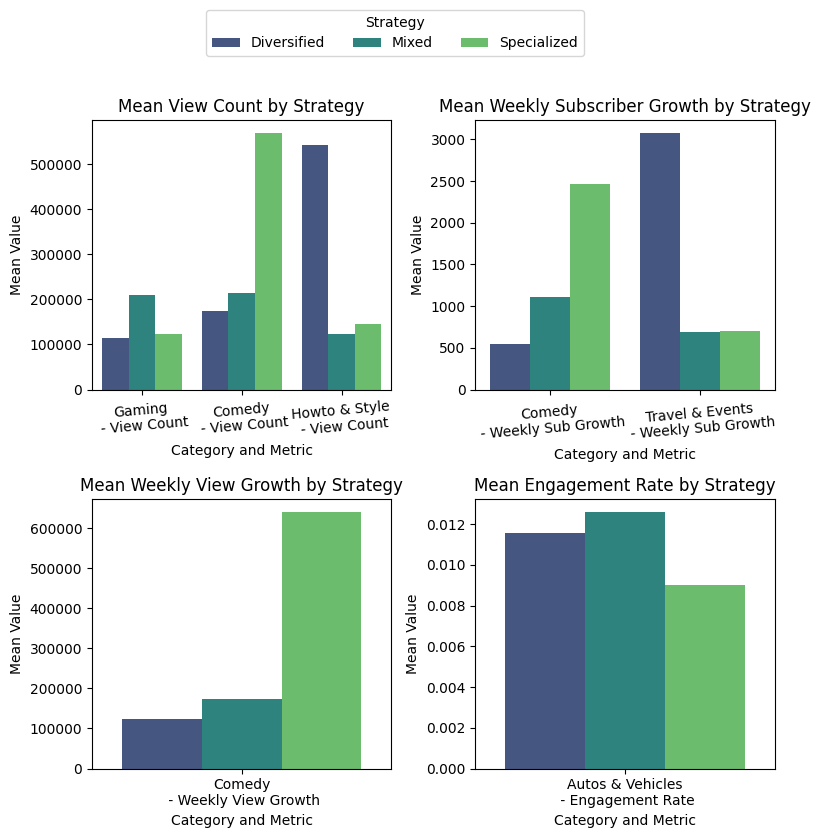

In [23]:
from src.utils.content import metrics_plot_insights

# Creating a plot for metrics
metrics_plot_insights(significant_means)

**Specialized Strategy**: Suitable for the Comedy channel, where audiences prefer specific content styles. Using a specialized strategy can effectively increase view counts and subscriber growth.

**Mixed Strategy**: Suitable for Gaming and Autos & Vehicles channels, which need a balance between diversity and focus to attract a broader audience.

**Diversified Strategy**: Suitable for Howto & Style and Travel & Events channels, where audiences have a high demand for diverse content. A diversified strategy can attract more audience interest.

### *IDEA2: Analysis of video duration*
We are interested in the impact of video duration. Will people prefer a longer video as they may get more knowledge, or they prefer a short video for passing time? We can explore this by investigating three aspects: optimal video length for different categories, the impact of video length on viewer engagement and channel growth, and the evolution of audience preferences for video length over time. Also, we are going to develop a method to evaluate the popular degree of a video, then focus on the relationship between video duration and popular degree.



#### Mathematical Details

**Videa Popularity Score**:

For each video, a preliminary method to evaluate the popular degree of a video was obtained by normalizing and redistributing different weights based on the number of views, likes, and comments:

$PS = 0.5\frac{\ln(1+V)}{\ln(1+V_{max})} + 0.3\frac{\ln(1+L)}{\ln(1+L_{max})} + 0.2\frac{\ln(1+C)}{\ln(1+C_{max})}$, where:

$V$ = views

$L$ = likes

$C$ = comments

$V_{max}, L_{max}, C_{max}$ = maximum values across dataset

$\ln(1+x)$ transformation reduces skewness

           categories  year  max_view_count_duration  max_like_count_duration  max_num_comms_duration  max_popularity_score_duration
0    Autos & Vehicles  2006                 1.571667                 1.755000                1.650000                       1.755000
1    Autos & Vehicles  2007                 5.588333                 5.176667                3.988333                       5.425000
2    Autos & Vehicles  2008                 7.730000                 8.095000                5.858333                       8.146667
3    Autos & Vehicles  2009                 4.130000                 5.030000                5.606667                       5.036667
4    Autos & Vehicles  2010                 5.020000                 8.013333                6.230000                       6.916667
..                ...   ...                      ...                      ...                     ...                            ...
213   Travel & Events  2015                 8.366667                 

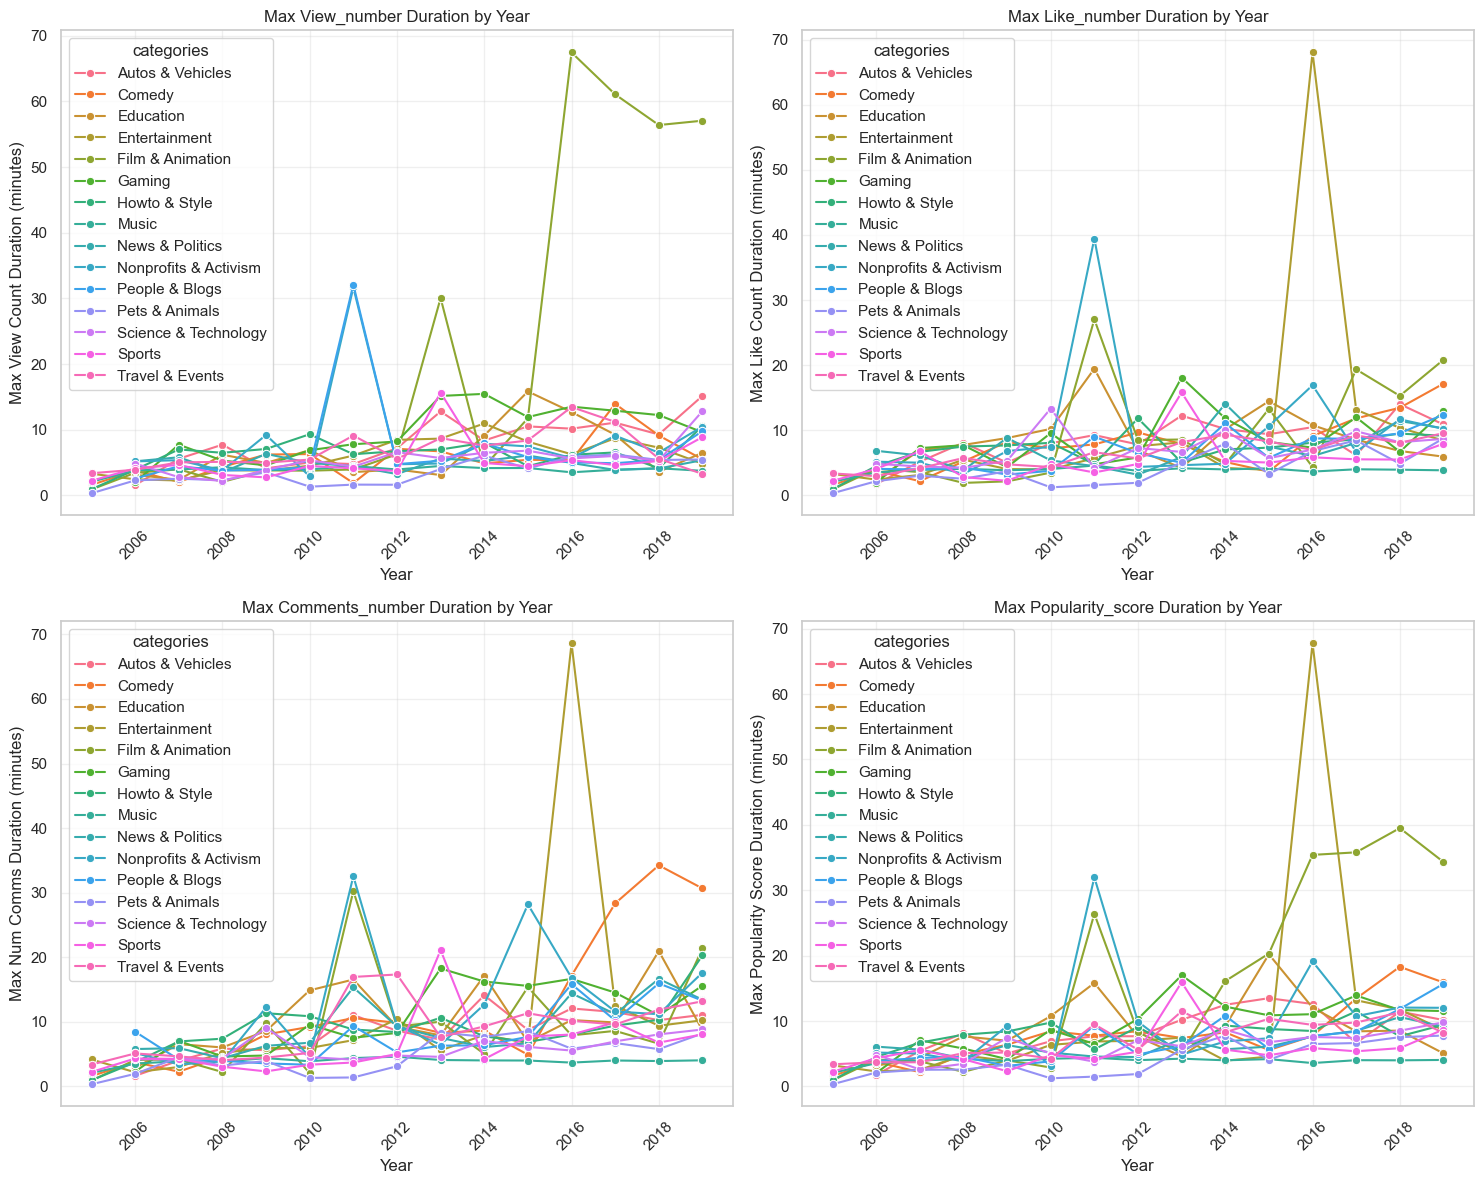

In [24]:
from src.utils.duration import optimal_video_length, plot_max_duration

# Duration analysis of different categories
pd.set_option('display.max_columns', None)
pd.set_option('display.width',1000)
optimal_durations_df = optimal_video_length(df_metadata, df_comments)
print(optimal_durations_df)
plt_max_duration = plot_max_duration(optimal_durations_df)

**Optimal video length for different categories**

In the above analysis, we have provided the mean duration of the ten beat videos corresponding to different categories and years under the criteria of maximum number of views, maximum number of likes, maximum number of comments, and best popularity score. 
The optimal video length under the category of Music always tends to be shorter, while category of Film & Animation, Entertainment, and Comedy have sometimes achieved better playback effects in recent years. Especially from 2016 to 2019, the optimal video length for different categories gradually became differentiated.

Based on the 2019 optimal video length data for different categories, here's a comprehensive summary:
1. By Duration Groups:
- Short-Form Content (Under 10 minutes):
    - Music: 3-4 minutes
    - Entertainment: 4-10 minutes
    - Education: 5-10 minutes
    - Pets & Animals: 5-10 minutes
    - Sports: 5-10 minutes

- Medium-Length Content (5-20 minutes):
    - Gaming: 10-15 minutes
    - People & Blogs: 10-15 minutes 
    - Autos & Vehicles: 10-15 minutes
    - Nonprofits & Activism: 10-15 minutes
    - News & Politics: 5-15 minutes
    - Howto & Style: 10-20 minutes
    - Science & Technology: 5-15 minutes
    - Travel & Events: 3-15 minutes

- Flexible Duration (Wider Range):
    - Film & Animation: 20-60 minutes
    - Comedy: 5-30 minutes

2. Observations:
- Music videos have the shortest optimal length (3-4 minutes)
- Film & Animation has the longest range (20-60 minutes)
- Most categories fall within the 5-15 minute range
- Entertainment-focused content (Gaming, Comedy) can sustain longer durations

These duration guidelines can help content creators optimize their video lengths according to their category, potentially improving watch-through rates and audience engagement. The data suggests that different types of content have distinct optimal lengths based on viewer preferences and content requirements.

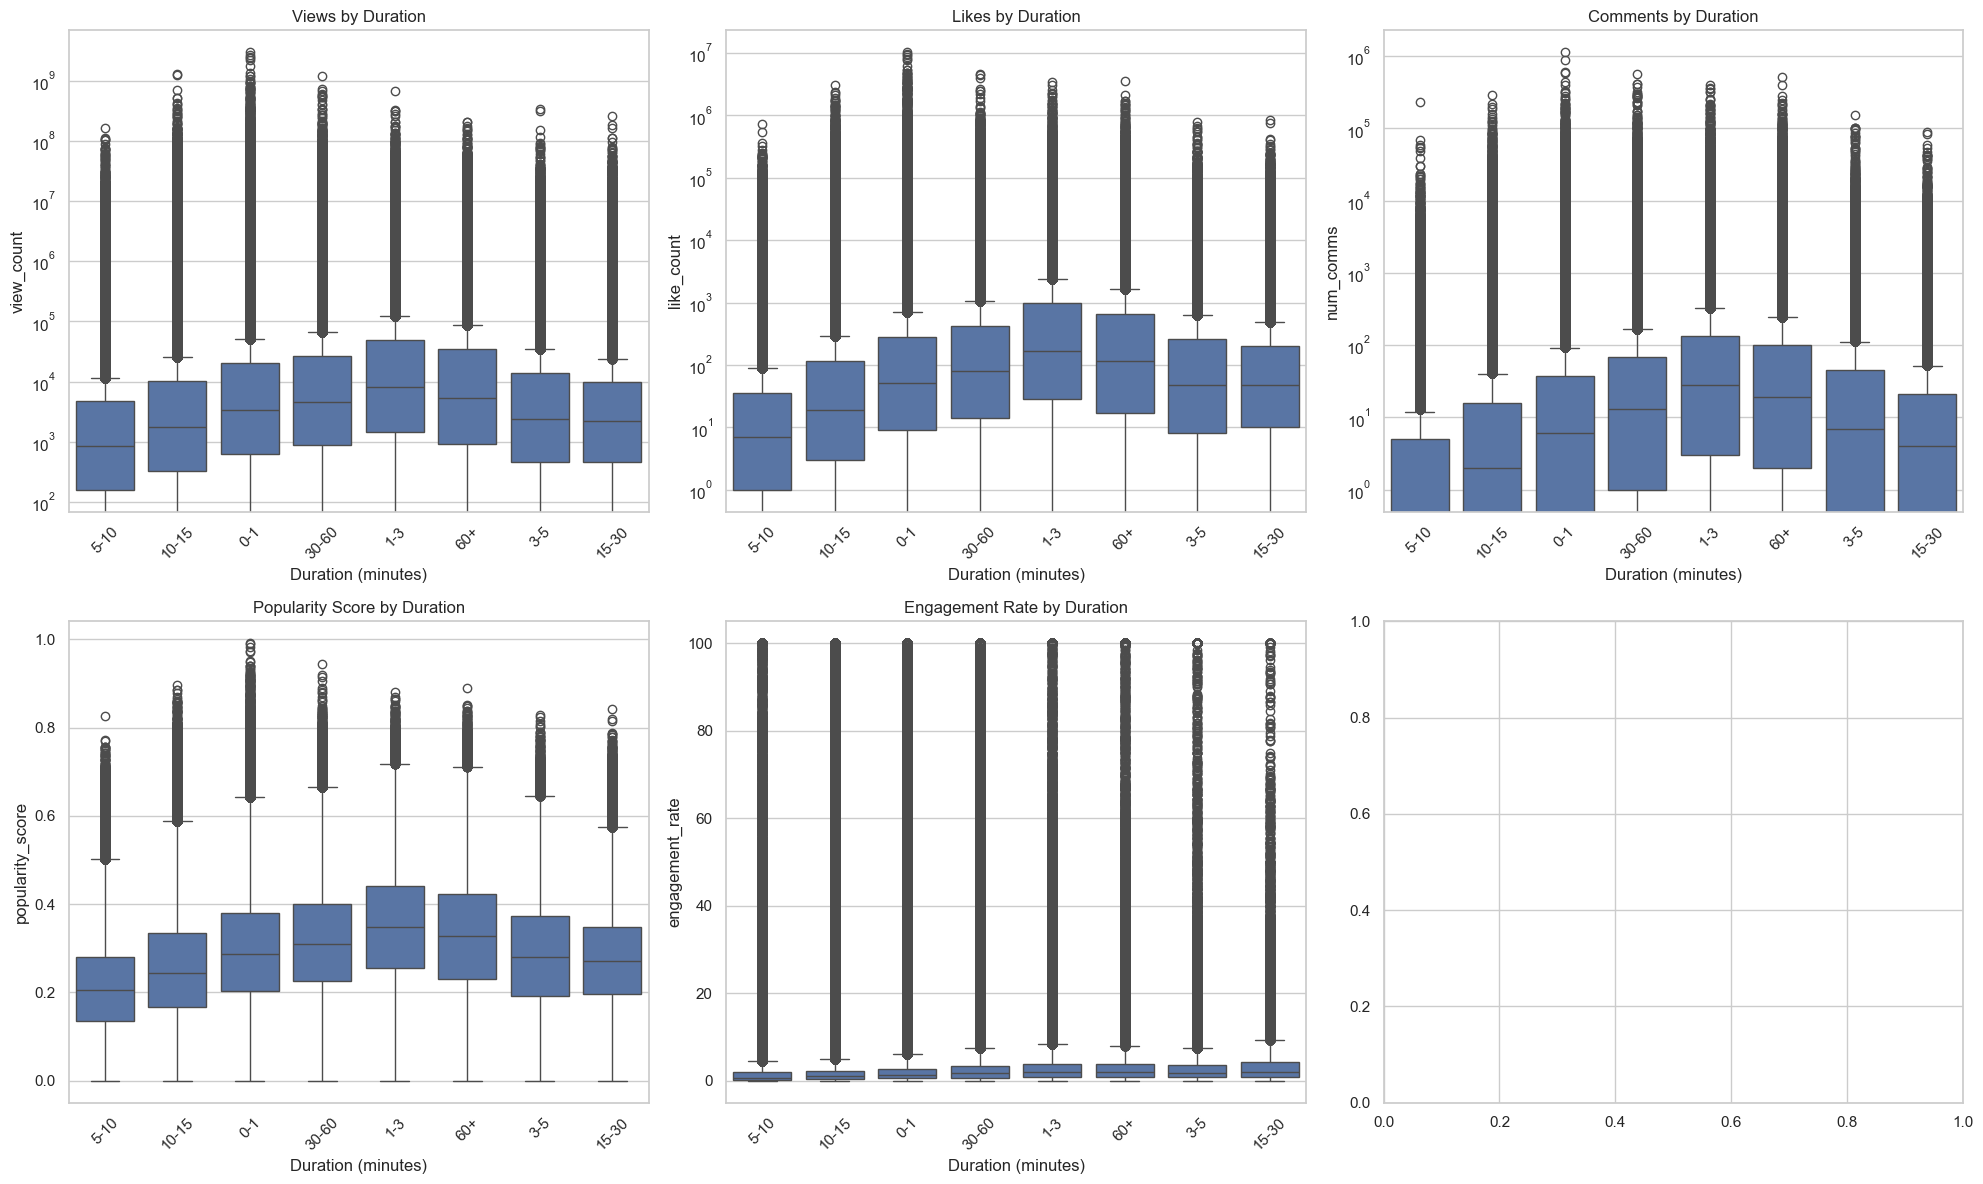

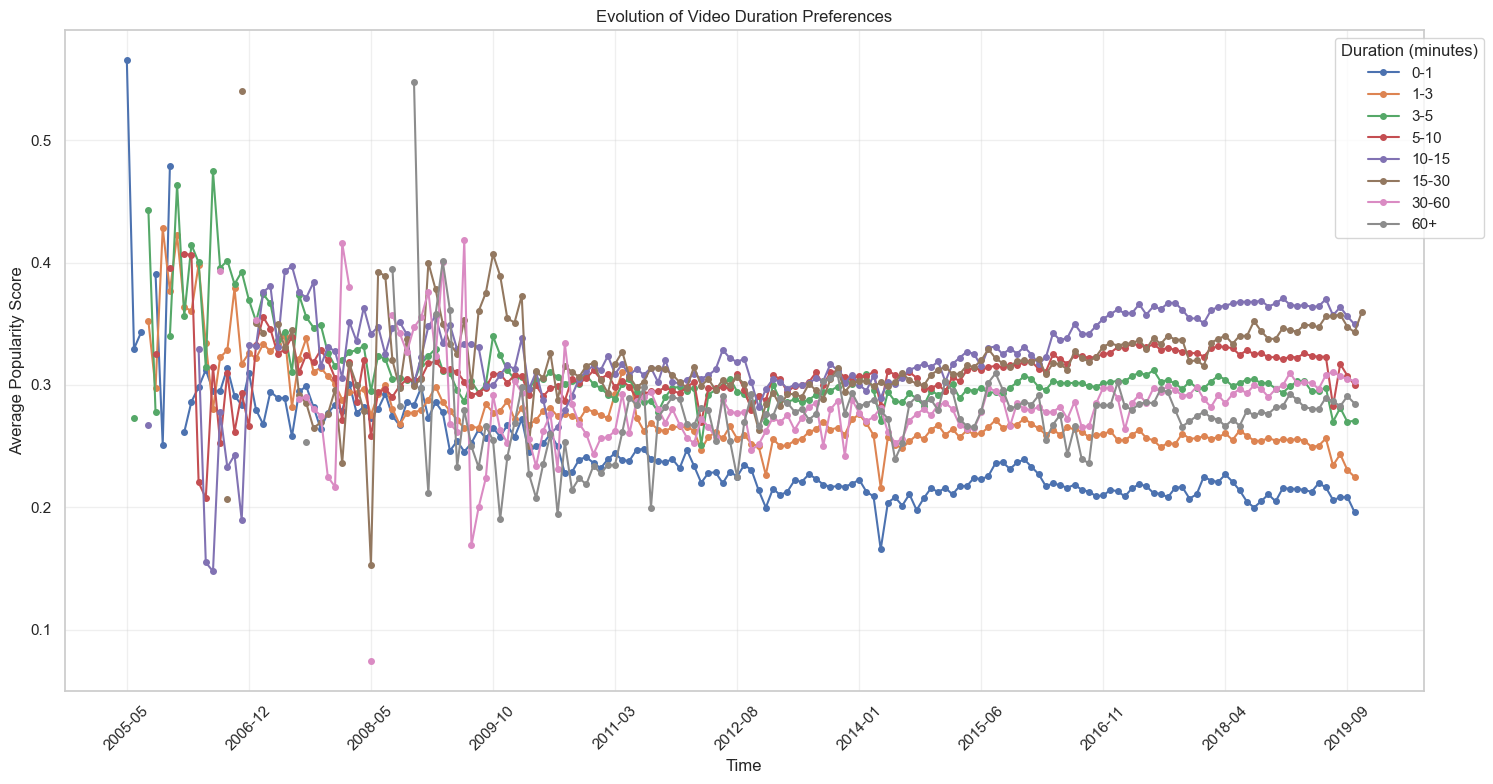

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Roaming\\Python\\Python39\\site-packages\\matplotlib\\pyplot.py'>

In [25]:
from src.utils.duration import analyze_duration_metrics, plot_engagement_metrics, analyze_temporal_trends

# Popularity analysis of different duration
df_analysis = analyze_duration_metrics(df_metadata, df_comments)
plot_engagement_metrics(df_analysis.copy())
analyze_temporal_trends(df_analysis.copy())

**Impact of video length on viewer engagement and channel growth**

- Overall data from 2005 to 2019 showed that shorter videos (1-3 minutes) and longer videos (30-60 minutes, over 60 minutes) typically achieve better playback effects and relatively higher audience engagement. In addition, although 15-30 minute videos do not have the highest audience engagement compared to videos of other durations, the average audience engagement performance is better.
- It indicates that 1-3 minute videos have the potential for viral success (shown by high outliers in the boxplot), but 10-15 minute videos show better and more consistent performance overall (shown by higher averages in the line graph).

**Evolution of audience preferences for video length over time**

Since 2016, the average popularity scores of different video lengths have gradually become distinguishable. Videos of 10-15 minutes and 15-30 minutes have more advantages. On the contrary, shorter videos of 0-1 minutes and 1-3 minutes perform the worst on YouTube.


#### **So What Happened Since 2016?**
Through online search, we found some interesting facts on the evolution of video length on YouTube since 2016:

1. **The Shift in Content Length**

    In the early days of YouTube, videos typically lasted around seven to eight minutes. However, today's platform landscape looks drastically different, dominated by longer content that stretches well beyond the ten-minute mark. This transformation didn't happen by chance; it's the result of a carefully crafted ecosystem that rewards longer content through various mechanisms.

2. **The Money Factor: Why Length Matters**

    The financial incentive behind longer videos is compelling, primarily driven by YouTube's advertising structure. The crucial ten-minute threshold allows creators to insert mid-roll advertisements in addition to pre-roll ads, opening up significantly more monetization opportunities. Take content creator Shelby Church's experience: by simply extending her videos from seven minutes to thirteen minutes, she saw her monthly earnings jump from \$1800 to \\$6000. Surprisingly, she discovered that longer videos not only generated more income but also attracted larger audiences, creating a win-win situation that further incentivized creators to produce extended content.

3. **The TikTok Effect**

    The launch of TikTok in 2017 marked a significant turning point in the digital content landscape. Short-form content creators found a new home on TikTok, where the format was not just accepted but celebrated. This migration naturally led to a decrease in short-form content on YouTube, as creators specialized their content for each platform. Viewers too began to associate TikTok with quick, snappy content, while turning to YouTube for more in-depth, longer-form videos. This natural segregation of content types between platforms further reinforced YouTube's position as the go-to platform for long content.

4. **Creator Adaptation and Platform Evolution**

    This shift has rippled across all content categories. Beauty channels now produce 30-40 minute tutorials, commentary videos regularly exceed half an hour, and even apology videos have grown longer. Popular creators like Jake and Logan Paul have extended their content from under 10 minutes to 25 minutes. What's remarkable is that creators aren't necessarily changing their content style – they're simply allowing their stories to breathe and expand.

5. **The Algorithm's Role**

    YouTube's algorithm plays a crucial part in this transformation. The platform's recommendation system favors content that keeps viewers engaged and on the site longer. As Lindsay Ellis, a video essayist, points out, "YouTube doesn't care about how many videos you watch, they just want you to stay on YouTube." This preference for engagement time over video count has fundamentally shaped how content is created and consumed on the platform.

6. **The New Normal**

    According to Pew Research Center, videos from the top 250,000 channels now average between 13 and 14 minutes. This new standard has given rise to different content formats: in-depth political analysis, documentary series, luxury vlogs, and detailed tutorials. A 30-minute video, once considered unusually long, has become commonplace. This evolution reflects a perfect alignment between platform goals, creator incentives, and changing viewer habits, establishing a new era of long-form content on YouTube.



### *Why our plan is reasonable and sound?*

Based on the above research, we can summarize the reasons why our plan is reasonable and sound:
1. **Data-driven Approach**
    - Comprehensive dataset analysis of YouTube metadata, timeseries, comments and channels
    - Rich insights into content strategy, video duration and engagement
    - Cross-validation through multiple data sources
2. **Progressive Analysis Layers**
    - From single metrics to multi-dimensional analysis
    - From overall trends to category-specific comparisons
    - Dual validation through visualization and statistics
3. **Rigorous Methodology**
    - ANOVA testing ensures statistical reliability
    - Composite scoring system balances multiple metrics
    - Time-series analysis captures temporal evolution
4. **Analysis Comprehensiveness**
    - Cross-dataset validation
    - Multiple performance metrics covered
    - Major content categories analyzed


### *Further Analysis in P3*
1. **Diversity Outlier Investigation**
    - Analyze highly successful diversified channels
    - Study their unique strategies and characteristics
    - Compare with specialized channels in similar categories
    - Identify key differentiating factors

2. **Major Event Impact Analysis**
    - Select years with significant industry events
    - Track video duration trends before and after
    - Study impact across different content types
    - Example: How gaming livestream emergence affected gaming video length

3. **Diversity-Duration Interaction Effects**
    - Build multiple regression models
    - Analyze optimal duration at different diversity levels
    - Study how duration moderates diversification strategy effectiveness
    - Identify optimal combinations

These directions could deepen current findings and reveal more YouTube content operation patterns.